In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from rfest import splineLG, splineLNP
from rfest.utils import get_n_samples, uvec, split_data, build_design_matrix
from rfest.simulate import V1complex_2d, flickerbar, get_response
from rfest.metrics import mse

In [9]:
def plot_RF(w, dims, title=''):
    vmax = np.max([np.abs(w.max()), np.abs(w.min())])
    fig, ax = plt.subplots()
    im = ax.imshow(w.reshape(dims), cmap=plt.cm.bwr, vmin=-vmax, vmax=vmax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)
    fig.colorbar(im)
    plt.show()

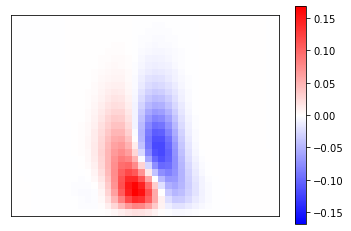

In [10]:
w_true = V1complex_2d()

dims = w_true.shape
dt = 0.033

plot_RF(w_true, dims)

In [4]:

dims = w_true.shape
n_features = np.prod(dims)
n_samples = int(n_features * 64)
# n_samples = get_n_samples(64, dt)
dt = 1.

# white noise
X_wn = flickerbar(n_samples=n_samples, dims=dims, design_matrix=True, random_seed=2046)
y_wn = get_response(X_wn, w_true.flatten(), dt=dt)

X_pn = flickerbar(n_samples=n_samples, dims=dims, beta=1, design_matrix=True, random_seed=2046)
y_pn = get_response(X_pn, w_true.flatten(), dt=dt)

In [5]:
from rfest import ASD, ALD

# white noise
asd_wn = ASD(X_wn, y_wn, dims=dims)
asd_wn.fit(p0=[1., 1., 7., 6.,], num_iters=30, verbose=10)

sigma0 = [1.]
rho0 = [1.]
params_t0 = [3., 20., 1., 1.] # taus, nus, tauf, nuf
params_y0 = [3., 20., 1., 1.]
p0 = sigma0 + rho0 + params_t0 + params_y0
ald_wn = ALD(X_wn, y_wn, dims=dims)
ald_wn.fit(p0=p0, num_iters=30, verbose=10)

# pink noise
asd_pn = ASD(X_pn, y_pn, dims=dims)
asd_pn.fit(p0=[1., 1., 7., 6.,], num_iters=30, verbose=10)

sigma0 = [1.]
rho0 = [1.]
params_t0 = [3., 20., 1., 1.] # taus, nus, tauf, nuf
params_y0 = [3., 20., 1., 1.]
p0 = sigma0 + rho0 + params_t0 + params_y0
ald_pn = ALD(X_pn, y_pn, dims=dims)
ald_pn.fit(p0=p0, num_iters=30, verbose=10)

Iter	σ	ρ	δt	δs	cost
   0	1.010	0.990	7.010	6.010	145935.143
  10	1.107	1.000	7.083	6.107	140203.858
  20	1.194	1.033	7.174	6.187	137156.239
Stop: reached 30 steps, final cost=135756.86477.
* Due to space limit, parameters for frequency domain are not printed.
Iter	σ	ρ	τ_t	ν_t	τ_y	ν_y	cost
   0	1.010	1.010	3.010	19.990	3.010	20.010	137201.256
  10	1.107	0.987	3.006	19.977	2.985	20.021	131165.791
  20	1.194	0.951	3.008	20.008	2.939	19.995	127837.972
Stop: reached 30 steps, final cost=126281.31368.
Iter	σ	ρ	δt	δs	cost
   0	1.010	0.990	7.010	6.010	210574.186
  10	1.108	0.951	7.076	6.080	193849.143
  20	1.199	0.929	7.117	6.133	182842.676
Stop: reached 30 steps, final cost=176301.51111.
* Due to space limit, parameters for frequency domain are not printed.
Iter	σ	ρ	τ_t	ν_t	τ_y	ν_y	cost
   0	1.010	1.010	3.010	19.990	3.010	19.990	201861.808
  10	1.108	1.016	2.981	20.042	2.981	19.990	184834.244
  20	1.199	1.010	2.982	20.064	2.950	20.006	173613.130
Stop: reached 30 steps, final cost=166916.70579

In [6]:
num_random = 10
num_iters = 5000
scale_factor = np.array([0.5, 1, 2, 4, 8, 16, 32, 64])
rnd_seed_list = np.arange(num_random)
n_samples_list = (n_features * scale_factor).astype(int)

dis_all = []
dis_norm_all = []
wn_ws_all = []

for ii, rnd_seed in enumerate(rnd_seed_list):

    res_w_sta = []
    res_w_mle = []
    res_w_asd = []
    res_w_ald = []
    res_w_spl_mle = []
    res_w_spl_fit = []
    
    X_wn = flickerbar(n_samples=int(n_features * 64), dims=dims, design_matrix=True, random_seed=2046)
    y_wn = get_response(X_wn, w_true.flatten(), dt=dt)

    print(f'rnd_seed={rnd_seed}')


    for jj, n_samples in enumerate(n_samples_list):
        
        print(f'Calculating n_samples={n_samples} | scale_factor={scale_factor[jj]}')

        w_sta_wn = X_wn[:n_samples].T @ y_wn[:n_samples] / n_samples
        w_mle_wn = np.linalg.inv(X_wn[:n_samples].T @ X_wn[:n_samples]) @ X_wn[:n_samples].T @ y_wn[:n_samples]

        w_asd_wn = asd_wn.optimized_C_post @ X_wn[:n_samples].T @ y_wn[:n_samples] / asd_wn.optimized_params[0]**2
        w_ald_wn = ald_wn.optimized_C_post @ X_wn[:n_samples].T @ y_wn[:n_samples] / ald_wn.optimized_params[0]**2

        lg = splineLG(X_wn[:n_samples], y_wn[:n_samples], dims=dims, dt=dt, df=df)
        lg.fit(num_iters=num_iters, verbose=0, tolerance=10, beta=0.01)    
    
        res_w_sta.append(w_sta_wn)
        res_w_mle.append(w_mle_wn)

        res_w_asd.append(w_asd_wn)
        res_w_ald.append(w_ald_wn)
        
        res_w_spl_mle.append(lg.w_spl)
        res_w_spl_fit.append(lg.w_opt)
        
    res_w_sta = np.array(res_w_sta)
    res_w_mle = np.array(res_w_mle)
    res_w_asd = np.array(res_w_asd)
    res_w_ald = np.array(res_w_ald) 
    res_w_spl_mle = np.array(res_w_spl_mle)
    res_w_spl_fit = np.array(res_w_spl_fit)
    
    res_ws = [res_w_sta, res_w_mle, res_w_asd, res_w_ald, res_w_spl_mle, res_w_spl_fit]
    wn_ws_all.append(res_ws)    

else:
    print('Done.')

rnd_seed=0
Calculating n_samples=600 | scale_factor=0.5
Total time elapsed: 63.386 s.
Calculating n_samples=1200 | scale_factor=1.0
Total time elapsed: 66.500 s.
Calculating n_samples=2400 | scale_factor=2.0
Total time elapsed: 67.551 s.
Calculating n_samples=4800 | scale_factor=4.0
Total time elapsed: 68.767 s.
Calculating n_samples=9600 | scale_factor=8.0
Total time elapsed: 73.488 s.
Calculating n_samples=19200 | scale_factor=16.0
Total time elapsed: 96.084 s.
Calculating n_samples=38400 | scale_factor=32.0
Total time elapsed: 131.790 s.
Calculating n_samples=76800 | scale_factor=64.0
Total time elapsed: 219.489 s.
rnd_seed=1
Calculating n_samples=600 | scale_factor=0.5
Total time elapsed: 37.689 s.
Calculating n_samples=1200 | scale_factor=1.0
Total time elapsed: 20.649 s.
Calculating n_samples=2400 | scale_factor=2.0
Total time elapsed: 66.535 s.
Calculating n_samples=4800 | scale_factor=4.0
Total time elapsed: 87.134 s.
Calculating n_samples=9600 | scale_factor=8.0
Total time ela

In [7]:
wn_dis_norm_all = []
for res_ws in wn_ws_all:
    dis_norm = np.vstack([[mse(uvec(w_true.flatten()), uvec(w)) for w in ws] for ws in res_ws])
    wn_dis_norm_all.append(dis_norm)   
wn_dis_norm_all = np.vstack(wn_dis_norm_all)
wn_dis_norm_all_reshape = wn_dis_norm_all.reshape(len(rnd_seed_list), 6, 8)    

In [8]:
dis_all = []
dis_norm_all = []
pn_ws_all = []

for ii, rnd_seed in enumerate(rnd_seed_list):

    res_w_sta = []
    res_w_mle = []
    res_w_asd = []
    res_w_ald = []
    res_w_spl_mle = []
    res_w_spl_fit = []
    
    X_pn = flickerbar(n_samples=int(n_features * 64), dims=dims, beta=1, design_matrix=True, random_seed=2046)
    y_pn = get_response(X_pn, w_true.flatten(), dt=dt)
    print(f'rnd_seed={rnd_seed}')

    for jj, n_samples in enumerate(n_samples_list):
        
        print(f'Calculating n_samples={n_samples} | scale_factor={scale_factor[jj]}')

        w_sta_pn = X_pn[:n_samples].T @ y_pn[:n_samples] / n_samples
        w_mle_pn = np.linalg.pinv(X_pn[:n_samples].T @ X_pn[:n_samples]) @ X_pn[:n_samples].T @ y_pn[:n_samples]

        w_asd_pn = asd_pn.optimized_C_post @ X_pn[:n_samples].T @ y_pn[:n_samples] / asd_pn.optimized_params[0]**2
        w_ald_pn = ald_pn.optimized_C_post @ X_pn[:n_samples].T @ y_pn[:n_samples] / ald_pn.optimized_params[0]**2
    
        lg = splineLG(X_pn[:n_samples], y_pn[:n_samples], dims=dims, dt=dt, df=df)
        lg.fit(metric='corrcoef',
              num_iters=num_iters, verbose=0, tolerance=10,
              beta=0.01)
    
        res_w_sta.append(w_sta_pn)
        res_w_mle.append(w_mle_pn)

        res_w_asd.append(w_asd_pn)
        res_w_ald.append(w_ald_pn)
        
        res_w_spl_mle.append(lg.w_spl)
        res_w_spl_fit.append(lg.w_opt)
        
    res_w_sta = np.array(res_w_sta)
    res_w_mle = np.array(res_w_mle)
    res_w_asd = np.array(res_w_asd)
    res_w_ald = np.array(res_w_ald) 
    res_w_spl_mle = np.array(res_w_spl_mle)
    res_w_spl_fit = np.array(res_w_spl_fit)
      
    res_ws = [res_w_sta, res_w_mle, res_w_asd, res_w_ald, res_w_spl_mle, res_w_spl_fit]
    pn_ws_all.append(res_ws)    

else:
    print('Done.')

rnd_seed=0
Calculating n_samples=600 | scale_factor=0.5
Total time elapsed: 67.186 s.
Calculating n_samples=1200 | scale_factor=1.0
Total time elapsed: 69.457 s.
Calculating n_samples=2400 | scale_factor=2.0
Total time elapsed: 71.983 s.
Calculating n_samples=4800 | scale_factor=4.0
Total time elapsed: 72.878 s.
Calculating n_samples=9600 | scale_factor=8.0
Total time elapsed: 73.069 s.
Calculating n_samples=19200 | scale_factor=16.0
Total time elapsed: 96.181 s.
Calculating n_samples=38400 | scale_factor=32.0
Total time elapsed: 105.301 s.
Calculating n_samples=76800 | scale_factor=64.0
Total time elapsed: 227.757 s.
rnd_seed=1
Calculating n_samples=600 | scale_factor=0.5
Total time elapsed: 66.985 s.
Calculating n_samples=1200 | scale_factor=1.0
Total time elapsed: 47.573 s.
Calculating n_samples=2400 | scale_factor=2.0
Total time elapsed: 69.808 s.
Calculating n_samples=4800 | scale_factor=4.0
Total time elapsed: 68.877 s.
Calculating n_samples=9600 | scale_factor=8.0
Total time ela

In [9]:
pn_dis_norm_all = []
for res_ws in pn_ws_all:
    dis_norm = np.vstack([[mse(uvec(w_true.flatten()), uvec(w)) for w in ws] for ws in res_ws])
    pn_dis_norm_all.append(dis_norm)   
pn_dis_norm_all = np.vstack(pn_dis_norm_all)
pn_dis_norm_all_reshape = pn_dis_norm_all.reshape(len(rnd_seed_list), 6, 8)    

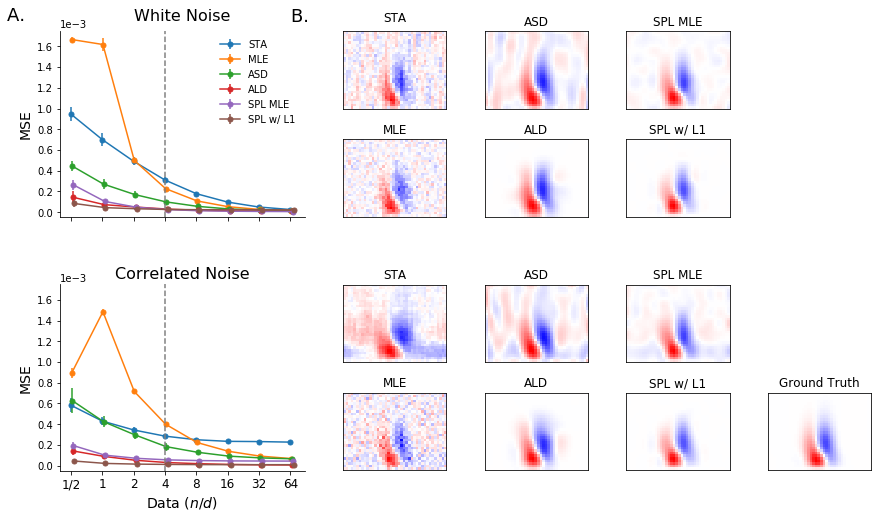

In [10]:
def panel_specs(layout, fig=None):
    # default arguments
    if fig is None:
        fig = plt.gcf()
    # format and sanity check grid
    lines = layout.split('\n')
    lines = [line.strip() for line in lines if line.strip()]
    linewidths = set(len(line) for line in lines)
    if len(linewidths)>1:
        raise ValueError('Invalid layout (all lines must have same width)')
    width = linewidths.pop()
    height = len(lines)
    panel_letters = set(c for line in lines for c in line)-set('.')
    # find bounding boxes for each panel
    panel_grid = {}
    for letter in panel_letters:
        left = min(x for x in range(width) for y in range(height) if lines[y][x]==letter)
        right = 1+max(x for x in range(width) for y in range(height) if lines[y][x]==letter)
        top = min(y for x in range(width) for y in range(height) if lines[y][x]==letter)
        bottom = 1+max(y for x in range(width) for y in range(height) if lines[y][x]==letter)
        panel_grid[letter] = (left, right, top, bottom)
        # check that this layout is consistent, i.e. all squares are filled
        valid = all(lines[y][x]==letter for x in range(left, right) for y in range(top, bottom))
        if not valid:
            raise ValueError('Invalid layout (not all square)')
    # build axis specs
    gs = gridspec.GridSpec(ncols=width, nrows=height, figure=fig)
    specs = {}
    for letter, (left, right, top, bottom) in panel_grid.items():
        specs[letter] = gs[top:bottom, left:right]
    return specs, gs

def panels(layout, fig=None):
    axes = {}
    # default arguments
    if fig is None:
        fig = plt.gcf()
    specs, gs = panel_specs(layout, fig=fig)
    for letter, spec in specs.items():
        axes[letter] = fig.add_subplot(spec)
    return axes, gs

def label_panel(ax, letter, *, prefix='', postfix='.', spaces=6, pad=10, fontsize=18):
    ax.set_title(prefix+letter+postfix+' '*spaces, loc='left', pad=pad,
                 fontdict={'horizontalalignment': 'right',
                           'fontsize': fontsize})

def label_panels(axes, letters=None, *, prefix='', postfix='.', spaces=6, pad=10, fontsize=18):
    if letters is None:
        letters = axes.keys()
    for letter in letters:
        ax = axes[letter]
        label_panel(ax, letter, prefix=prefix, postfix=postfix, spaces=spaces, pad=pad, fontsize=fontsize)
    
layout = '''
 AABDF.
 AACEG.
 ......
 IIJLN.
 IIKMOP
 '''

fig = plt.figure(figsize=(12, 7))
axes, spec = panels(layout, fig=fig)
spec.set_width_ratios([1., 1., 1., 1., 1., 1.])
spec.set_height_ratios([1., 1., 0.1 , 1., 1., ])

col = 3
ws = np.vstack([[w[col] for w in wn_ws_all[0]], w_true.flatten()])
# ws = np.delete(ws, 3, axis=0)
# wn_dis_norm_all_reshape = np.delete(wn_dis_norm_all_reshape, 3, axis=1)
titles = ['STA', 'MLE', 'ASD', 'ALD', 'SPL MLE', 'SPL w/ L1', 'Ground Truth']
for ii, letter in enumerate('BCDEFG'):
    vmax = np.max([np.abs(ws[:][ii].max()), np.abs(ws[:][ii].min())])
    
    axes[letter].set_xticks([])
    axes[letter].set_yticks([])
    
    axes[letter].imshow(ws[:][ii].reshape(dims), cmap=plt.cm.bwr, vmin=-vmax, vmax=vmax)
    axes[letter].set_title(titles[ii])
    
ws = np.vstack([[w[col] for w in pn_ws_all[0]], w_true.flatten()])

for ii, letter in enumerate('JKLMNOP'):
    vmax = np.max([np.abs(ws[:][ii].max()), np.abs(ws[:][ii].min())])
    
    axes[letter].set_xticks([])
    axes[letter].set_yticks([])
    
    axes[letter].imshow(ws[:][ii].reshape(dims), cmap=plt.cm.bwr, vmin=-vmax, vmax=vmax)
    axes[letter].set_title(titles[ii])
    
# for ii, letter in enumerate('abcdefg'):
#     axes[letter].axis('off')
    
for i in range(6):
    x = np.arange(8)
#     y = dis_all_reshape.mean(0)[i]
#     yerr = dis_all_reshape.std(0)[i]
    y = wn_dis_norm_all_reshape.mean(0)[i]
    yerr = wn_dis_norm_all_reshape.std(0)[i]
   
    axes['A'].errorbar(x=x+0.02*i, y=y, yerr=yerr, marker='o', markersize=5, label=titles[:-1][i])

# axes['A'].set_xticks(np.arange(8))
# xticklabel = ['1/2', '1', '2', '4', '8', '16', '32', '64']
# axes['A'].set_xticklabels(xticklabel, fontsize=12)
axes['A'].set_xticklabels([])
axes['A'].ticklabel_format(axis='y', style='sci', useOffset=True, scilimits=(0,0))
# axes['A'].set_ylim(0, 0.003)

axes['A'].spines['right'].set_visible(False)
axes['A'].spines['top'].set_visible(False)
# axes['A'].set_xlabel('$n/d$')
axes['A'].set_ylabel('MSE', fontsize=14)
axes['A'].legend(frameon=False)
axes['A'].set_title('White Noise', fontsize=16)
axes['A'].axvline(col, color='grey', ls='--', zorder=99)

for i in range(6):
    x = np.arange(8)
    y = pn_dis_norm_all_reshape.mean(0)[i]
    yerr = pn_dis_norm_all_reshape.std(0)[i]
   
    axes['I'].errorbar(x=x+0.02*i, y=y, yerr=yerr, marker='o', markersize=5, label=titles[:-1][i])

axes['I'].set_xticks(np.arange(8))
xticklabel = ['1/2', '1', '2', '4', '8', '16', '32', '64']
axes['I'].set_xticklabels(xticklabel, fontsize=12)
axes['I'].ticklabel_format(axis='y', style='sci', useOffset=True, scilimits=(0,0))

axes['I'].spines['right'].set_visible(False)
axes['I'].spines['top'].set_visible(False)
axes['I'].set_xlabel('Data ($n/d$)', fontsize=14)
axes['I'].set_ylabel('MSE', fontsize=14)
axes['I'].set_title('Correlated Noise', fontsize=16)
# axes['G'].legend(frameon=False)

axes['I'].axvline(col, color='grey', ls='--', zorder=99)

axes['A'].set_ylim(-0.00005, 0.00175)
axes['I'].set_ylim(-0.00005, 0.00175)


label_panels(axes, letters='AB')  
plt.tight_layout(pad=0, w_pad=-1, h_pad=1)
plt.savefig(f'figs/fig2.pdf', bbox_inches='tight', pad_inches = 0.1)